<h1><center><font size="6">Breast Cancer Detection</font></center></h1>

# Outline
- [Import necessary Libraries](#1)
- [Introduction](#2)
- [Exploratory Data Analysis](#3)
- [Data Preprocessing](#4)
- [Model Selection](#5)
- [Model Training](#6)
    - [Logistic Regression](#6.1)
    - [K Neighbors Classifier](#6.2)
- [Model evaluation](#7)
    - [Accuracy](#7.1)
    - [Confusion Matrix](#7.2)
    - [Precision, recall and f1-score](#7.3)
- [References](#8)

<a id='1'></a>
# Import necessary Libraries

In [1]:
# Import necessary libraries and print their versions
from platform import python_version
print(f"Python: {python_version()}")
import pickle
import numpy as np
print(f"Numpy: {np.__version__}")
import pandas as pd
print(f"Pandas: {pd.__version__}")
import sklearn
print(f"Scikit-Learn: {sklearn.__version__}")
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
print(f"Seaborn: {sns.__version__}")
import matplotlib
print("Matplotlib: {}".format(matplotlib.__version__))
import matplotlib.pyplot as plt
%matplotlib inline

Python: 3.9.16
Numpy: 1.24.1
Pandas: 1.5.2
Scikit-Learn: 1.2.0
Seaborn: 0.12.2
Matplotlib: 3.6.3


<a id='2'></a>
# Introduction
Machine learning is a subset of **Artificial Intelligence (AI)** that has taken the world by storm. In healthcare, you can see how machine learning can simplify manual processes, benefiting patients, providers and pharmaceutical companies alike. Google, for example, has developed a machine learning algorithm that can detect cancer tumors on mammograms. Similarly, Stanford University has developed a deep learning algorithm to detect skin cancer. In this notebook, we will look at how we can use machine learning to detect breast cancer. To do this, we will use **logistic regression** and the **KNN** algorithm.

The flow chart below shows the individual steps of the project:

![Flow Chart](pictures/breast_cancer_detection_flowchart.png)

In the next chapter we will perform an Exploratory Data Analysis to get a more detailed overview of the data.

<a id='3'></a>
# Exploratory Data Analysis
In machine learning, it is very important to understand the data we are going to use. This helps us choose which algorithm to use and understand the results we are actually looking for.

In [2]:
# Get names for the column from dataset description
names = [
    "id",
    "clump_thickness",
    "uniform_cell_size",
    "uniform_cell_shape",
    "marginal_adhesion",
    "single_epithelial_size",
    "bare_nuclei",
    "bland_chromatin",
    "normal_nucleoli",
    "mitoses",
    "class",
]
# Load the data
data = pd.read_csv("../data/breast-cancer-wisconsin.data", names=names)
# Take a quick look at the first five rows
data.head()

,id,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


This breast cancer databases was obtained from the University of Wisconsin Hospitals. These are factors that a pathologist would consider to determine if a cell has cancer:
- **Clump Thickness**
- **Uniformity of Cell Size**
- **Uniformity of Cell Shape**
- **Marginal Adhesion**
- **Single Epithelial Cell Size**
- **Bare Nuclei**
- **Bland Chromatin**
- **Normal Nucleoli**
- **Mistoses**
- **Class**

Every variable has values ranging from 1-10 except the prediction variable **Class**. Here the value **2** stands for **benign** and **4** for **malignant**. **Benign** means it is non-cancerous and **malignant** means it is cancerous.

We omit the column **id**, as it does not provide us with any information.

In [3]:
# Drop id column
data.drop("id", axis=1, inplace=True)

In [4]:
# Show unique values of each column
for col in data:
    print(data[col].unique())

[ 5  3  6  4  8  1  2  7 10  9]
[ 1  4  8 10  2  3  7  5  6  9]
[ 1  4  8 10  2  3  5  6  7  9]
[ 1  5  3  8 10  4  6  2  9  7]
[ 2  7  3  1  6  4  5  8 10  9]
['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']
[ 3  9  1  2  4  5  7  8  6 10]
[ 1  2  7  4  5  3 10  6  9  8]
[ 1  5  4  2  3  7 10  8  6]
[2 4]


Here we look at the different values for the individual variables. We notice that the sixth column (**bare_nuclei**) also has a question mark as a value. This indicates missing values in the data set, which we need to correct.

In [5]:
# Count how often a value is in the bare_nuclei column
data["bare_nuclei"].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [6]:
# Replace ? with nan
data.replace("?", np.nan, inplace=True)

As we can see, values are missing sixteen times. We will replace these places with the median and thus fill the gaps.

In [7]:
# Clean and prepare data
data["bare_nuclei"].fillna(data["bare_nuclei"].median(), inplace=True)

In [8]:
data["bare_nuclei"].value_counts()

1      402
10     132
2       30
5       30
3       28
8       21
4       19
1.0     16
9        9
7        8
6        4
Name: bare_nuclei, dtype: int64

In [9]:
# Print the shape of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   clump_thickness         699 non-null    int64 
 1   uniform_cell_size       699 non-null    int64 
 2   uniform_cell_shape      699 non-null    int64 
 3   marginal_adhesion       699 non-null    int64 
 4   single_epithelial_size  699 non-null    int64 
 5   bare_nuclei             699 non-null    object
 6   bland_chromatin         699 non-null    int64 
 7   normal_nucleoli         699 non-null    int64 
 8   mitoses                 699 non-null    int64 
 9   class                   699 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


In [10]:
# Convert bare_nuclei column to integer
data["bare_nuclei"] = pd.to_numeric(data["bare_nuclei"]).astype("int64")
# Check if everything worked correctly
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   clump_thickness         699 non-null    int64
 1   uniform_cell_size       699 non-null    int64
 2   uniform_cell_shape      699 non-null    int64
 3   marginal_adhesion       699 non-null    int64
 4   single_epithelial_size  699 non-null    int64
 5   bare_nuclei             699 non-null    int64
 6   bland_chromatin         699 non-null    int64
 7   normal_nucleoli         699 non-null    int64
 8   mitoses                 699 non-null    int64
 9   class                   699 non-null    int64
dtypes: int64(10)
memory usage: 54.7 KB


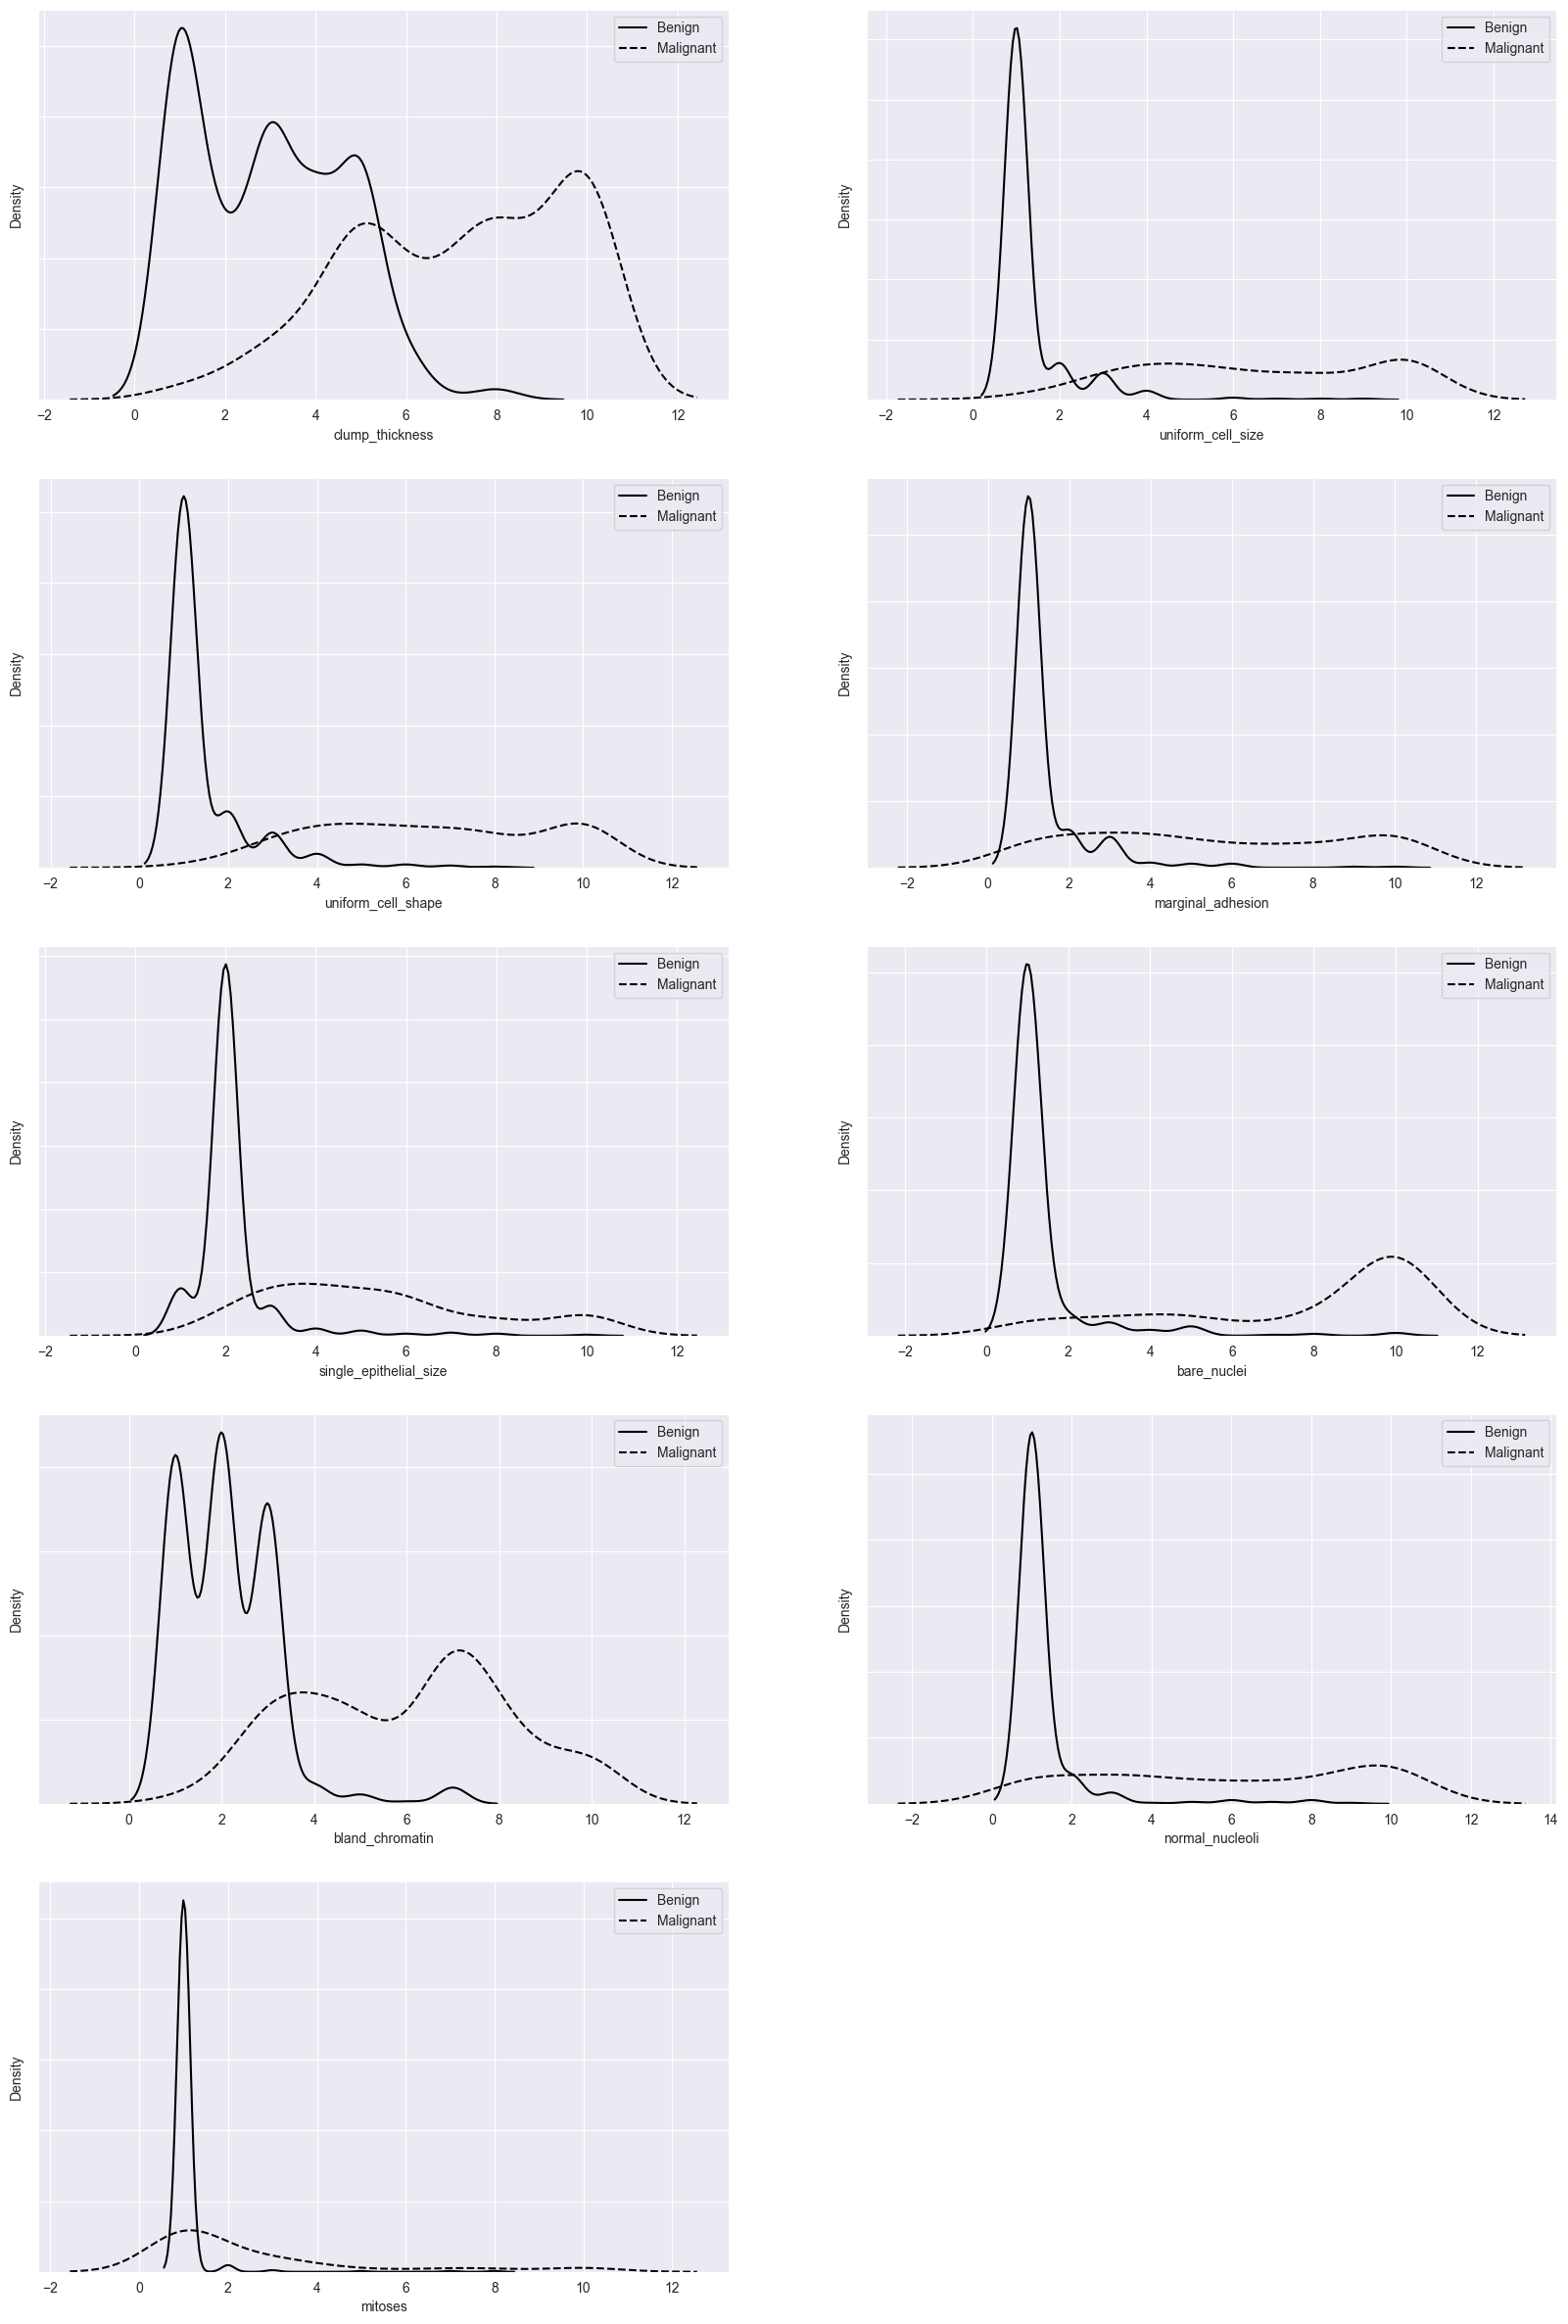

In [11]:
# Create a subplot of 3x3
plt.subplots(5, 2, figsize=(20, 30))
# Plot a density plot for each variable
for idx, col in enumerate(data.columns):
    ax = plt.subplot(5, 2, idx + 1)
    ax.yaxis.set_ticklabels([])
    sns.kdeplot(data.loc[data["class"] == 2][col], warn_singular=False, color="black")
    sns.kdeplot(
        data.loc[data["class"] == 4][col],
        warn_singular=False,
        color="black",
        linestyle="dashed",
    )
    ax.legend(["Benign", "Malignant"])
# Hide the 10th subplot since it is the prediction column
plt.subplot(5, 2, 10).set_visible(False)
plt.show()

As you can see, most of the histograms for benign (straight line) so far are in the range of 1, with some data having a slightly higher value. If we look at the histograms for malignant (dashed line), we can see that there is a significant difference in the distribution. The values for benign are easy to distinguish from the values for malignant. IIn other words, most of the variables are good predictors of breast cancer.

<a id='4'></a>
# Data Preprocessing
After the exploratory data analysis, we will do the data processing. First, we check the balance of the target variables and then split the data into test and training data.

In [12]:
# Check the balance of the target variable
data["class"].value_counts()

2    458
4    241
Name: class, dtype: int64

In [13]:
# Create train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["class"])

<a id='5'></a>
# Model selection
Now that we have completed the exploratory data analysis and data processing, let's turn to creating two models that we can train with our data.

In the previous section, we split our data into the classical test and training data. The test data set will only be used at the end to validate our model, which we select in this section (hold-out set). For the evaluation, we will use a metric called cross-validation in combination with our training data. Cross-validation is a statistical method for evaluating generalisation performance that is more stable and consistent than splitting into a training set and a test set. Cross-validation instead splits the data repeatedly. The most commonly used version of cross-validation is k-fold cross-validation, where k is a number set by the user, usually 5 or 10. In five-fold cross-validation, the data are first divided into five equal parts, called folds. The model is trained using the first fold as the test set, and the remaining folds (2-5) are used as training sets. The model is built using the data in folds 2-5, and accuracy is then assessed for fold 1. Another model is then created, this time using fold 2 as the test set and the data in folds 1, 3-5 as the training set. This process is repeated with folds 3, 4 and 5 as test sets. For each of these five splits of the data into training and test sets, the accuracy is calculated. At the end, we have collected five accuracy values. This process is shown in the following figure:

![Cross-Validation](pictures/cross_validation.png)
*Source: https://scikit-learn.org/stable/modules/cross_validation.html*

Dividing the data set into k folds by starting with the first one-kth part of the data is not always a good idea. For example, if 90% of the data belongs to class A and 10% of the data belongs to class (in our case: 2 (~66%) and 4 (~34%)), then stratified cross-validation is a good idea. It ensures that in each fold 90 % of the samples belong to class A and 10 % of the data belong to class B. It is usually a good idea to use stratified k-fold cross-validation instead of k-fold cross-validation to evaluate a classifier, as it leads to more reliable estimates of generalization performance. This process is illustrated in the following figure:

![Stratified Cross-Validation](pictures/stratified_cross_validation.png)
*Source: https://scikit-learn.org/stable/modules/cross_validation.html*

In [14]:
# Model classification
def classification_model(model, data, predictors, outcome, n_splits=10, stratify=False):
    """
    Performs cross-validation with a defined model

    Parameters
    ----------
    model:
        Model for cross-validation
    data: pandas DataFrame
        Dataframe containing the data on which the model is to be trained
    predictors: list
        List of variables representing the predictors
    outcome: str
        The outcome variable that the model should predict
    n_splits: int (default=10)
        Number that determines how often the data is to be split
    stratify: bool (default=False)
        Parameter indicating whether a stratified cross-validation is to be carried
        out or not

    Returns
    ----------
    Outputs a print statement with the model name, the mean cross-validation result
    and the standard deviation of the cross-validation result
    """
    model_name = type(model).__name__
    if not stratify:
        # Prepare the cross-validation procedure
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        # Evaluate the model
        cv_results = cross_val_score(
            model, data[predictors], data[outcome], cv=kfold, scoring="accuracy"
        )
        print(
            f"{model_name}: {round(cv_results.mean(),4)} accuracy with a standard deviation of {round(cv_results.std(),4)}"
        )

    if stratify:
        # Prepare the cross-validation procedure
        stratified_kfold = StratifiedKFold(
            n_splits=n_splits, shuffle=True, random_state=42
        )
        # Evaluate the model
        cv_results = cross_val_score(
            model,
            data[predictors],
            data[outcome],
            cv=stratified_kfold,
            scoring="accuracy",
        )
        print(
            f"{model_name}: {round(cv_results.mean(),4)} accuracy with a standard deviation of {round(cv_results.std(),4)}"
        )

<a id='6'></a>
# Model training
Now we can finally train our models. We start with logistic regression as the first model.
<a id='6.1'></a>
## Logistic Regression
One of the most popular classification algorithms is logistic regression. In logistic regression, a linear output is converted into a probability between 0 and 1 using the sigmoid function:
$$ \sigma(x) = \frac{1}{1+e^{-x}}$$
In the equation above $x$ is the set of predictor features. Computing $\sigma(x)$ above produces a probability that indicates if an observation should be classified as 1 (if the calculated probability is at least 0.5), and a 0 otherwise. In our case would the 1 indicate a malignant and the 0 a benign. The following figure illustrates this process:

![Logistic Regression](pictures/logistic-regression.png)
*Source: https://www.javatpoint.com/linear-regression-vs-logistic-regression-in-machine-learning*



In [15]:
# Logistic Regression
predictor_var = [
    "clump_thickness",
    "uniform_cell_size",
    "uniform_cell_shape",
    "marginal_adhesion",
    "single_epithelial_size",
    "bare_nuclei",
    "bland_chromatin",
    "normal_nucleoli",
    "mitoses",
]
outcome_var = "class"
model = LogisticRegression(max_iter=1000)
classification_model(model, train_data, predictor_var, outcome_var, stratify=True)

LogisticRegression: 0.966 accuracy with a standard deviation of 0.0168


<a id='6.2'></a>
## K Neighbors Classifier
The KNN algorithm is probably the simplest machine learning algorithm. In its simplest version, the KNN algorithm only considers exactly one nearest neighbour, i.e. the data point closest to the point for which we want to make a prediction. So it is a classification algorithm where learning is based on how similar one data point is to another. Below is an image with one data point not yet classified (question mark) and all the other data already classified (star and lightning), each assigned to a particular class (A or B). The KNN algorithm calculates the distance between our new data and all the others to know which data has the smallest distance. So you take 3 (or 7) of the closest data points (neighbours) and check which class is the most common. In the case of the image below, the closest data points to the new data in the first circle are 3 data points, 2 of which are stars. The new data point would therefore be classified as a star. How many neighbours (k) the algorithm should include in the calculation is a parameter that can be set beforehand. The best choice of k depends on the data; in general, larger values of k reduce the effects of noise on classification, but make the boundaries between classes less clear. A good k can be chosen by various heuristic methods such as hyperparameter tuning.

![KNN](pictures/KNN.png)

To calculate the distance between the already classified data and the new data there are several ways. One of those is the Euclidean distance, the formula for this looks like the following:

$$ d(p,q) = \sqrt{\sum_{i=1}^{n}{(q_i - p_i)^{2}}} $$

Attributes:
- $p,q$ = Two points in the Euclidean n-space
- $q_i,p_i$ = Euclidean vectors, starting from the origin of the space (initial point)
- $n$ =  n-space


In [16]:
# K Neighbors Classifier
predictor_var = [
    "clump_thickness",
    "uniform_cell_size",
    "uniform_cell_shape",
    "marginal_adhesion",
    "single_epithelial_size",
    "bare_nuclei",
    "bland_chromatin",
    "normal_nucleoli",
    "mitoses",
]
outcome_var = "class"
model = KNeighborsClassifier()
classification_model(model, train_data, predictor_var, outcome_var, stratify=True)

KNeighborsClassifier: 0.9696 accuracy with a standard deviation of 0.0212


<a id='7'></a>
# Model evaluation
After we have successfully trained our models, we proceed with the model with the best performance (KNN) and evaluate it against the test set.
<a id='7.1'></a>
## Accuracy

In [17]:
# Make predictions on test set
predictor_var = [
    "clump_thickness",
    "uniform_cell_size",
    "uniform_cell_shape",
    "marginal_adhesion",
    "single_epithelial_size",
    "bare_nuclei",
    "bland_chromatin",
    "normal_nucleoli",
    "mitoses",
]
outcome_var = "class"
model.fit(train_data[predictor_var], train_data[outcome_var])
predictions = model.predict(test_data[predictor_var])
print(f"KNN: {accuracy_score(test_data[outcome_var], predictions)}")

KNN: 0.9785714285714285


In the previous output, it can be seen that the KNN algorithm achieved 98% accuracy for the test set. The **accuracy** is defined as the percentage of correct predictions for the test data. It can be easily calculated by dividing the number of correct predictions by the number of total predictions.
$$ accuracy = \frac{correct\:predictions}{all\:predictions}$$
Here is another formula with regard to the next chapter:
$$ accuracy = \frac{TP+TN}{TP+TN+FP+FN} $$

<a id='7.2'></a>
## Confusion Matrix
The confusion matrix is a useful visualisation tool that allows an analysis of the true negative, false positive, false negative and true positive results of our model. In addition to a simple accuracy metric, we should also look at the confusion matrix to understand the performance of the model. The definition of true negative, false positive, false negative and true positive is as follows:
- **True negative**: The true class is negative (no breast cancer), and the model predicted negative (no breast cancer).
- **False positive**: The actual class is negative (no breast cancer), but the model predicted positive (breast cancer).
- **False negative**: The actual class is positive (breast cancer), but the model predicted negative (no breast cancer).
- **True positive**: The actual class is positive (breast cancer), and the model predicted positive (breast cancer).

Clearly, the number of false positives and false negatives should be as low as possible and the number of true negatives and true positives as high as possible. The result for this model is as follows:

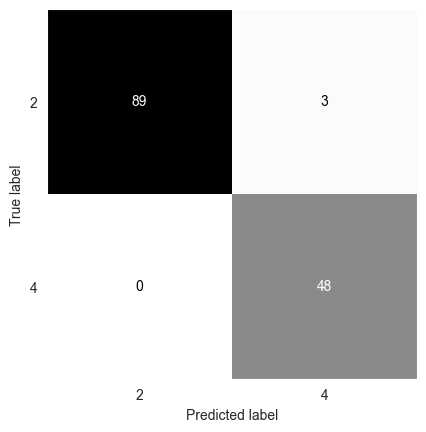

In [18]:
# Confusion matrix
cm = confusion_matrix(test_data[outcome_var], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Greys", colorbar=False)
plt.grid(False)
plt.show()

The confusion matrix shows that most of the predictions are true negatives and true positives. The remaining predictions are 3 false positives, which is undesirable. In the detection of breast cancer, a false negative is perhaps even more harmful than a false positive. A false negative means that the patient is told that she will not develop breast cancer when in fact she will.

<a id='7.3'></a>
## Precision, recall and f1-score
There are several other ways to summarise the confusion matrix, the most common being **precision** and **recall**. The **precision** measures how many of the samples predicted to be positive are actually positive:
$$ precision = \frac{TP}{TP+FP} $$
Precision is used as a performance measure when the goal is to limit the number of false positives. As an example, imagine a model designed to predict whether a new drug will be effective in treating a disease in clinical trials. Clinical trials are notoriously expensive, and a pharmaceutical company will only want to conduct an experiment if it is very certain that the drug will actually work. Therefore, it is important that the model does not produce many false positives - in other words, that it has high precision.

The **recall**, on the other hand, measures how many of the positive samples are covered by the positive predictions:
$$ recall = \frac{TP}{TP+FN} $$
Recall is used as a performance measure when all positive samples need to be identified, i.e. when it is important to avoid false negatives. In our scenario, breast cancer detection is a good example of this, as mentioned earlier: it is important to find all diseased individuals, possibly including healthy patients in the prediction.

There is a trade-off between optimising recall and optimising accuracy. You can trivially achieve perfect recall if you predict all samples as positive - there are then no false negatives, but also no true negatives. However, if you predict all samples as positive, there are many false positives, so the precision is very low. On the other hand, if you find a model that predicts only the one data point it is most confident about as positive and the rest as negative, then the precision is perfect but the recall is very poor.

Precision and recall are very important measures, but looking at only one of them does not give us a complete picture. One way to summarise them is the **f1 score**, which is the harmonic mean of precision and recall:

$$ f1score = 2\cdot\frac{precision \cdot recall}{precision+recall} $$

The **f1-score** weights **precision** and **recall** equally:
- A model receives a high **f1-score** if both **precision** and **recall** are high.
- A model receives a low **f1-score** if both **precision** and **recall** are low.
- A model receives a medium **f1-score** if one of **precision** and **recall** is low and the other is high

The **f1-score** is a popular metric for classification models because, unlike accuracy, it provides robust results for both balanced and unbalanced datasets.

In [19]:
# Precision,recall and f1-score
print(classification_report(test_data[outcome_var], predictions))

              precision    recall  f1-score   support

           2       1.00      0.97      0.98        92
           4       0.94      1.00      0.97        48

    accuracy                           0.98       140
   macro avg       0.97      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



Overall, it can be said that we were able to create a good machine learning model that is able to detect breast cancer with an accuracy of **98%**. The last and final step is to save the model so that we can use it later.

In [20]:
# Save the model
filename = "breast_cancer_detection_model.pkl"
pickle.dump(model, open(filename, "wb"))

<a id='8'></a>
# References
1. [Numpy](https://numpy.org/doc/1.24/)
2. [Pandas](https://pandas.pydata.org/docs/)
3. [Matplotlib](https://matplotlib.org/)
4. [Seaborn](https://seaborn.pydata.org/api.html)
5. [Scikit-Learn](https://scikit-learn.org/stable/modules/classes.html)
6. [Diagrams](https://www.diagrams.net/)
7. [Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))